**Musical Instrument Detection** <br>
Theodore Matthew Patawari <br>
*26002104902* <br>
<br><br>
**Notes on this notebook:**<br>
1. This project was made in Google Colab, using the A100 Cloud GPU.

2. This notebook uses a dataset stored in Google Drive. The Drive link needs to loaded in correctly in order for the notebook to run.

3. When running the notebook, some data preprocessing/feature engineering related cells may be ignored in order to save computational power




In [ ]:
#importing packages
import numpy as np
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
from sklearn.model_selection import train_test_split
from PIL import Image
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvasAgg
from matplotlib.backends.backend_agg import FigureCanvas as FigureCanvas
import cv2
import itertools

from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import joblib


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
import torchvision

from IPython.display import Audio, display


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # uses GPU when available
print(device) # prints current device (to check if the GPU exists or not)

cuda


In [ ]:
def seed_torch(seed=0):
    '''
    This function is called to initialize a seed value
    PyTorch, Python Hash, and NumPy are seeded so that
    any operations utilizing randomly generated numbers
    will be reproducible

    The default seed is 0, but can be adjusted through the seed
    parameter
    '''
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)# if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch()


In [ ]:
from google.colab import drive
drive.mount('/content/drive') # mounts Google Drive (since the dataset is stored in Google Drive)

Mounted at /content/drive


In [ ]:
#Change the path if needed

PATH_TO_DATASET = 'drive/MyDrive/Music_Cover_Dataset_Processed' # path to the root folder of the dataset

In [ ]:
PATH = f'{PATH_TO_DATASET}/trimmed_5seconds/'#path to raw audios
PATH_PICKLE = f'{PATH_TO_DATASET}/pickle/'#path to pickle files
PATH_MODEL = f'{PATH_TO_DATASET}/models/'#path to model files

In [ ]:
INSTRUMENTS = ['piano', 'saxophone', 'violin', 'flute', 'harp', 'trumpet', 'guitar'] # list of instrumnets

In [ ]:
for ins in INSTRUMENTS: # print the amount of data samples per instruments
  all_files = [f for f in os.listdir(f'{PATH}{ins}')] # get list of all files from each instrument folder
  print(f'{ins}: {len(all_files)}') # print the length of the previous list

piano: 800
saxophone: 800
violin: 800
flute: 800
harp: 800
trumpet: 800
guitar: 800


Feature Engineeering Test

This section was made to show examples of the feature engineering processes used in this project

In [ ]:
'''
MEL SPECTROGRAM GENERATION TEST
'''

melspec_examples = {} # dictionary holding  mel spectrogram images

for ins in INSTRUMENTS:# loop through every instrument in the list
  all_files = [f for f in os.listdir(f'{PATH}{ins}')] # get all files from the dataset folder for a specific instrument
  idxs = np.random.choice(len(all_files), 3, replace=False) # select a random file from the list above (select a random index)
  y, sr = librosa.load(path = f'{PATH}{ins}/{all_files[idxs[0]]}') # load the first randomly selected file
  S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, # perform mel spec for the first randomly selected audio
                                   fmax=8000)

  y2, sr2 = librosa.load(path = f'{PATH}{ins}/{all_files[idxs[1]]}') # load the second randomly selected file
  S2 = librosa.feature.melspectrogram(y=y2, sr=sr2, n_mels=128,
                                   fmax=8000) # perform mel spec for the second randomly selected audio

  y3, sr3 = librosa.load(path = f'{PATH}{ins}/{all_files[idxs[2]]}') # load the third randomly selected file
  S3 = librosa.feature.melspectrogram(y=y3, sr=sr3, n_mels=128,
                                   fmax=8000) # perform mel spec for the third randomly selected audio

  melspec_examples[ins] = [S, S2, S3] # store the mel spectrograms into the dictionary

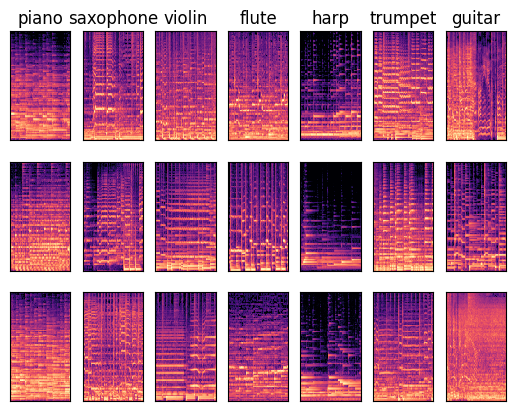

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols = len(INSTRUMENTS), sharex=True) # create figure to plot the mel spectrograms

for i in range(len(INSTRUMENTS)): # loop through every instrument name
  # display the first melspec of the current instrument
  img1 = librosa.display.specshow(librosa.power_to_db(melspec_examples[INSTRUMENTS[i]][0], ref=np.max),
                               fmax=8000,
                               ax=ax[0, i])

  # display the second melspec of the current instrument
  img2 =librosa.display.specshow(librosa.power_to_db(melspec_examples[INSTRUMENTS[i]][1], ref=np.max),
                               fmax=8000,
                               ax=ax[1, i])

  # display the third melspec of the current instrument
  img3 = librosa.display.specshow(librosa.power_to_db(melspec_examples[INSTRUMENTS[i]][2], ref=np.max),
                               fmax=8000,
                               ax=ax[2,i])

  ax[0,i].set(title=INSTRUMENTS[i]) # setting the title for every column in the figure

plt.show() # show the image

In [ ]:
'''
AUDIO FILTERING TEST
'''

ins_idx = np.random.choice(len(INSTRUMENTS)) # choose a random instrument

# get the list of all files from the instrument directory
all_files = [f for f in os.listdir(f'{PATH}{INSTRUMENTS[ins_idx]}')]
idx = np.random.choice(len(all_files)) # choose a random file

# print the instrument name and flename
print(f'{INSTRUMENTS[ins_idx]} {all_files[idx]}')

#load in the audio
y, sr = librosa.load(path = f'{PATH}{INSTRUMENTS[ins_idx]}/{all_files[idx]}')

#perform short-time fourier transform and isolate magnitude and phase data
S_full, phase = librosa.magphase(librosa.stft(y))

#use nearest neighbor filtering to create a filter
S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(0.5, sr=sr)))

#take the minimum between the unfiltered magnitude and filtered
S_filter = np.minimum(S_full, S_filter)


#initialize margin and power
margin_v = 5
power = 2

#create a mask such that foreground audio will be separated
mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

#use the mask on the magnitudes
S_foreground = mask_v * S_full

#use inverse isft to get audio
y_foreground = librosa.istft(S_foreground * phase)

#display the original audio
print("Original Audio Clip")
display(Audio(y, rate = sr))
print('\n\n\n')

#display the filtered audio
print("Filtered Audio Clip")
display(Audio(y_foreground, rate = sr))




trumpet trimmed_test14_11
Original Audio Clip






Filtered Audio Clip


Preparing Data


In [ ]:
raw_audio = {} # dictionary to store dataframes of the filtered audio, sorted
                # by instrument


for ins in INSTRUMENTS: # loop through all instrument names

  # check if there is a pickled file (if there is, just load it in and
  # skip the audio loading process)
  if os.path.exists(f'{PATH_PICKLE}raw_audio_filtered_{ins}.pkl'):
      print(f'Loading audio files of {ins} covers')

      # read pickle file and store in a dataframe
      df = pd.read_pickle(f'{PATH_PICKLE}raw_audio_filtered_{ins}.pkl')
      raw_audio[ins] = df #store dataframe in the dicitonary
      continue

  print(f'Extracting audio files of {ins} covers')

  # get all filenames of audio files
  filenames = [f for f in os.listdir(f'{PATH}{ins}')]
  print(f'{ins}: {len(filenames)}')
  counter = 0

  # set the column names of the dataframe
  dataset = pd.DataFrame(columns=['filename', 'audio', 'label'])
  for filename in filenames:
    try: # some audio might not be loaded in due to formatting issues

      # load the audio
      y, sr = librosa.load(path = f'{PATH}{ins}/{filename}')

      #perform STFT and retrieve magnitude inforation
      S_full, phase = librosa.magphase(librosa.stft(y))

      # perform nearest neighbor filtering
      S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

      # get the minimum magnitude between the filter and the magnitude
      S_filter = np.minimum(S_full, S_filter)

      margin_v = 5
      power = 2


      # create a mask to isolate foreground noise
      mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

      # Use the filter
      S_foreground = mask_v * S_full

      # use inverse STFT to generate the filtered audio
      y_foreground = librosa.istft(S_foreground * phase)

      #append the data to the dataframe
      dataset.loc[len(dataset.index)] = [filename, y_foreground, ins]

      if counter % 100 == 0: # loading text to indicate progress
        print(f'{counter*100//len(filenames)}% completed...')
      counter += 1
    except:
      print(f'{PATH}{ins}/{filename}')


  raw_audio[ins] = dataset #save the extracted and filtered audio to the dictionary

  #save pickled file
  dataset.to_pickle(f'{PATH_PICKLE}raw_audio_filtered_{ins}.pkl')
  print("saved pickle file")


Loading audio files of piano covers
Loading audio files of saxophone covers
Loading audio files of violin covers
Loading audio files of flute covers
Loading audio files of harp covers
Loading audio files of trumpet covers
Loading audio files of guitar covers


In [ ]:
#print shape of each audio data
torch.Tensor(raw_audio['piano'].iloc[1]['audio']).shape

torch.Size([110080])

In [ ]:
melspec = {} # dictionary to store melspec data


for ins in INSTRUMENTS: # loop through all instrument names

  # if a pickled file exists load it in and skip melspec generation
  if os.path.exists(f'{PATH_PICKLE}melspec_{ins}_filtered.pkl'):
      print(f'Loading melspec data of {ins} covers')

      #read pickle file into a dataframe
      df = pd.read_pickle(f'{PATH_PICKLE}melspec_{ins}_filtered.pkl')
      melspec[ins] = df # save the dataframe to a dictionary
      continue

  print(f'Extracting melspec from {ins} covers')


  # set the column names of the dataframe
  dataset = pd.DataFrame(columns=['filename', 'melspec', 'label'])
  counter = 0
  for row in range(len(raw_audio[ins])):

    # generate melspec with 128 mel-banks and a maximum frequency of 8000
    S = librosa.feature.melspectrogram(y=raw_audio[ins].iloc[row]['audio'], n_mels=128,
                                  fmax=8000)

    # append to the dataframe
    dataset.loc[len(dataset.index)] = [raw_audio[ins].iloc[row]['filename'], S, ins]

    # generate loading text to indicate progress
    if counter % 100 == 0:
      print(f'{counter*100//len(raw_audio[ins])}% completed...')
    counter += 1



  melspec[ins] = dataset # save dataframe to the melspec dictionary

  # save dataframe to a pickle file
  dataset.to_pickle(f'{PATH_PICKLE}melspec_{ins}_filtered.pkl')
  print("saved pickle file")

Loading melspec data of piano covers
Loading melspec data of saxophone covers
Loading melspec data of violin covers
Loading melspec data of flute covers
Loading melspec data of harp covers
Loading melspec data of trumpet covers
Loading melspec data of guitar covers


In [ ]:
specgram = {} # dictionary to store specgram data


for ins in INSTRUMENTS: # loop through all instrument names

  # if a pickled file exists load it in and skip melspec generation
  if os.path.exists(f'{PATH_PICKLE}specgram_{ins}_filtered.pkl'):
      print(f'Loading specgram data of {ins} covers')

      # load the pickle file to a dataframe
      df = pd.read_pickle(f'{PATH_PICKLE}specgram_{ins}_filtered.pkl')
      specgram[ins] = df # save the loaded dataframe to the dictionary
      continue

  print(f'Extracting specgram from {ins} covers')


  # set the column names of the dataframe
  dataset = pd.DataFrame(columns=['filename', 'specgram', 'label'])
  counter = 0
  for row in range(len(melspec[ins])):

    # convert amplitude to the decibel scale melspec
    img = librosa.amplitude_to_db(melspec[ins].iloc[row]['melspec'], ref=np.max)

    # create a figure with the aspect ration of the melspec
    fig, ax = plt.subplots(figsize=plt.figaspect(img))

    # draw the image on the figure
    librosa.display.specshow(img, ax=ax)
    canvas = FigureCanvas(fig)
    canvas.draw()

    plt.close()

    # convert the figure to an RGB image
    image_data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)

    # reshape the image
    image_data = image_data.reshape(canvas.get_width_height()[::-1] + (3, ))

    # convert the image into gray scale
    image_data = np.dot(image_data[..., :3], [0.2989, 0.5870, 0.1140])


    # save the grayscale specgram to the dataframe
    dataset.loc[len(dataset.index)] = [melspec[ins].iloc[row]['filename'], image_data, ins]

    # loading text to indicate progress
    if counter % 100 == 0:
      print(f'{counter*100//len(melspec[ins])}% completed...')
    counter += 1



  specgram[ins] = dataset # save the dataframe to the dictionary

  # save dataframe as a pickle file
  dataset.to_pickle(f'{PATH_PICKLE}specgram_{ins}_filtered.pkl')
  print("saved pickle file")

Loading specgram data of piano covers
Loading specgram data of saxophone covers
Loading specgram data of violin covers
Loading specgram data of flute covers
Loading specgram data of harp covers
Loading specgram data of trumpet covers
Loading specgram data of guitar covers


In [ ]:
# create a single dataset that fuses all dataframes
# storing individual instrument data
dataset = pd.concat(list(specgram.values()), axis=0)
print(len(dataset)) # print the length of the dataset

5600


Data Preparation

In [ ]:
# split dataset into train and test (test set takes 20% of the dataset)
train, test_val = train_test_split(dataset, test_size=0.2)

# split test set into test and validation (validation set takes 50% of the dataset)
test, val = train_test_split(test_val, test_size=0.5)

print('==TRAIN==')
print(train['label'].value_counts())

print('\n\n==TEST==')
print(test['label'].value_counts())

print('\n\n==VAL==')
print(val['label'].value_counts())

==TRAIN==
trumpet      656
piano        653
violin       646
harp         638
flute        633
guitar       628
saxophone    626
Name: label, dtype: int64


==TEST==
saxophone    89
harp         83
guitar       82
violin       81
trumpet      80
piano        73
flute        72
Name: label, dtype: int64


==VAL==
flute        95
guitar       90
saxophone    85
harp         79
piano        74
violin       73
trumpet      64
Name: label, dtype: int64


trumpet


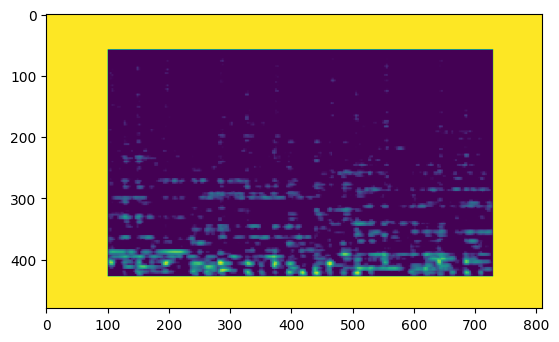

In [ ]:
dataset_sample_data = train.iloc[200]
print(dataset_sample_data['label'])
plt.imshow(dataset_sample_data['specgram'])
plt.show()

In [ ]:
class SpecGramDataset(Dataset):
    def __init__(self, dataframe, flatten_output = False, one_hot = True):
        self.dataframe = dataframe
        self.flatten_output = flatten_output
        self.one_hot = one_hot

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):

        x = self.dataframe.iloc[index][1]

        x = torch.Tensor(x)


        x = torchvision.transforms.functional.crop(x, top = 56, left = 100, height = 368, width = 610)

        x = x.reshape((1, x.shape[0], x.shape[1]))

        x = torch.nn.functional.normalize(x)

        if self.flatten_output:
          x = torch.flatten(x)
          #x = x.flatten()

        y = self.dataframe.iloc[index][2]
        if self.one_hot:
          one_hot = [0] * len(INSTRUMENTS)
          one_hot[INSTRUMENTS.index(self.dataframe.iloc[index][2])] = 1
          y = torch.Tensor(one_hot)


        return (x, y)

In [ ]:
#Deep Learning Data Loaders
train_set = SpecGramDataset(train)
test_set = SpecGramDataset(test)
val_set = SpecGramDataset(val)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=len(test), shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=True)

In [ ]:
#Machine Learning Data Loaders
train_set_ml = SpecGramDataset(train, flatten_output = True, one_hot = False)
test_set_ml = SpecGramDataset(test, flatten_output = True, one_hot = False)
val_set_ml = SpecGramDataset(val, flatten_output = True, one_hot = False)

train_loader_ml = DataLoader(train_set_ml, batch_size=32, shuffle=True)
test_loader_ml = DataLoader(test_set_ml, batch_size=len(test), shuffle=True)

In [ ]:
sample_data, sample_target = next(iter(train_loader))
print(f'Input data shape:  {sample_data[15].shape}')
print(f'Target shape:      {sample_target[15].shape}')

Input data shape:  torch.Size([1, 368, 610])
Target shape:      torch.Size([7])


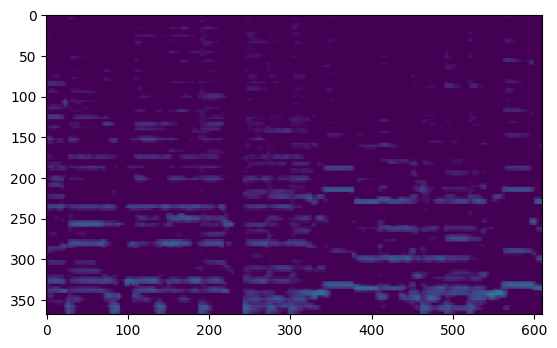

guitar


In [ ]:
idx = np.random.randint(0, 32)
im = torch.reshape(sample_data[idx], (sample_data[idx].shape[1], sample_data[idx].shape[2], 1))
#im = sample_data[idx]

plt.imshow(im)
plt.show()
print(INSTRUMENTS[sample_target[idx].nonzero()[0][0]])

Machine Learning Model

In [ ]:
seed_torch()
clf = GaussianNB()

filenames = [f for f in os.listdir(f'{PATH_MODEL}')]
if 'gaussian_nb.pkl' in filenames:
  print('Pretrained Model Found')
  clf = joblib.load(f'{PATH_MODEL}gaussian_nb.pkl')
else:
  classes = np.array(INSTRUMENTS)

  for i, data in enumerate(train_loader_ml):
    print(f"Iteration {i}")
    input_ml, label_ml = data
    clf.partial_fit(input_ml, label_ml, classes)

Pretrained Model Found


In [ ]:
accuracy = 0
test_loader_length = len(test_loader_ml)
for i, data in enumerate(test_loader_ml):
  input_ml, label_ml = data
  preds = clf.predict(input_ml)

  cur_acc = 0
  for k in range(len(preds)):
    if preds[k] == label_ml[k]:
      cur_acc += 1

  accuracy += cur_acc/len(preds)


print(f'Average accuracy: {(accuracy*100)/test_loader_length}%')


Average accuracy: 54.46428571428571%


In [ ]:
joblib.dump(clf, f'{PATH_MODEL}gaussian_nb.pkl')

['drive/MyDrive/Music_Cover_Dataset_Processed/models/gaussian_nb.pkl']

In [ ]:
y_true_ml = []
y_preds_ml = []
for i, data in enumerate(test_loader_ml):
    inputs, labels = data
    inputs, labels = inputs, labels
    predicted = clf.predict(inputs)

    y_true_ml.extend(labels)
    y_preds_ml.extend(predicted)

In [ ]:
print(y_true_ml)

['saxophone', 'trumpet', 'trumpet', 'harp', 'trumpet', 'flute', 'saxophone', 'harp', 'saxophone', 'flute', 'trumpet', 'flute', 'piano', 'trumpet', 'piano', 'guitar', 'saxophone', 'harp', 'piano', 'harp', 'trumpet', 'flute', 'saxophone', 'saxophone', 'violin', 'trumpet', 'flute', 'piano', 'violin', 'flute', 'flute', 'flute', 'flute', 'piano', 'piano', 'guitar', 'saxophone', 'saxophone', 'harp', 'flute', 'saxophone', 'saxophone', 'harp', 'trumpet', 'piano', 'piano', 'saxophone', 'harp', 'harp', 'harp', 'guitar', 'guitar', 'harp', 'violin', 'trumpet', 'violin', 'guitar', 'harp', 'trumpet', 'piano', 'trumpet', 'flute', 'guitar', 'trumpet', 'harp', 'flute', 'trumpet', 'guitar', 'guitar', 'guitar', 'harp', 'flute', 'trumpet', 'trumpet', 'saxophone', 'violin', 'harp', 'guitar', 'saxophone', 'guitar', 'saxophone', 'harp', 'piano', 'piano', 'violin', 'trumpet', 'trumpet', 'flute', 'guitar', 'saxophone', 'violin', 'saxophone', 'flute', 'guitar', 'harp', 'guitar', 'flute', 'harp', 'harp', 'violin

In [ ]:
print(classification_report(y_true_ml, y_preds_ml))

              precision    recall  f1-score   support

       flute       0.56      0.50      0.53        72
      guitar       0.66      0.43      0.52        82
        harp       0.71      0.78      0.74        83
       piano       0.40      0.70      0.51        73
   saxophone       0.57      0.44      0.49        89
     trumpet       0.67      0.39      0.49        80
      violin       0.44      0.59      0.51        81

    accuracy                           0.54       560
   macro avg       0.57      0.55      0.54       560
weighted avg       0.58      0.54      0.54       560



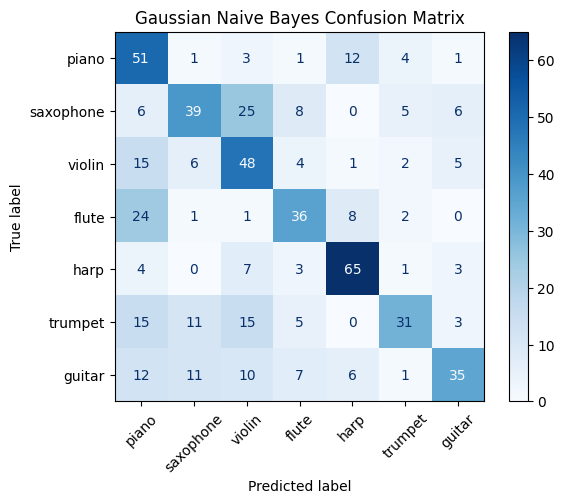

In [ ]:
conf_matrix = confusion_matrix(y_true_ml, y_preds_ml, labels = INSTRUMENTS)
conf_matrix_display = ConfusionMatrixDisplay(conf_matrix, display_labels=INSTRUMENTS)

conf_matrix_display.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Gaussian Naive Bayes Confusion Matrix")
plt.show()

In [ ]:
print(INSTRUMENTS)

['piano', 'saxophone', 'violin', 'flute', 'harp', 'trumpet', 'guitar']


Deep Learning Model

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        #input is (1, 368, 610)
        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=(2,2), stride = 2) #output shape: (6, 184, 305)
        self.act1 = torch.nn.LeakyReLU() #output shape: (6, 134, 305)
        self.maxpool1 = torch.nn.MaxPool2d(2) #output shape: (6, 92, 152)

        self.conv2 = torch.nn.Conv2d(6, 12, kernel_size=(2, 2), stride = 3) #output shape: (12, 30, 50)
        self.act2 = torch.nn.LeakyReLU() #output shape: (12, 30, 50)
        self.maxpool2 = torch.nn.MaxPool2d(2) #output shape: (12, 15, 25)



        self.flatten1 = torch.nn.Flatten(start_dim = 1)
        self.linear1 = torch.nn.Linear(12 * 15 * 25, 50)
        self.dropout = torch.nn.Dropout(p=0.1)
        self.linear2 = torch.nn.Linear(50, num_classes)
        self.softmax = torch.nn.Softmax(dim=1) #output shape = (num_classes)

    def forward(self, input):

        out = self.conv1(input)
        out = self.act1(out)
        out = self.maxpool1(out)

        out = self.conv2(out)
        out = self.act2(out)
        out = self.maxpool2(out)

        out = self.flatten1(out)
        out = self.linear1(out)
        out = self.dropout(out)
        out = self.linear2(out)

        res = self.softmax(out)

        return res

In [ ]:
def calculate_accuracy(output, target):
    correct = 0
    length = len(output)
    for i in range(length):
        pred = torch.argmax(output[i])
        truth = torch.argmax(target[i])

        if pred == truth:
          correct += 1

    return correct / length

In [ ]:
seed_torch(42)

model = Model(len(INSTRUMENTS))
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

training_loss_history = []
training_accuracy_history = []
validation_loss_history = []
validation_accuracy_history = []

num_epochs = 0
checkpoint_files = [f for f in os.listdir(f'{PATH_MODEL}')]
if 'deeplearning.pt' in checkpoint_files:
  print('Checkpoint file found')
  model_info = torch.load(f'{PATH_MODEL}deeplearning.pt')
  model.load_state_dict(model_info['model_state_dict'])
  training_loss_history = model_info['training_loss_history']
  training_accuracy_history = model_info['training_accuracy_history']
  validation_loss_history = model_info['validation_loss_history']
  validation_accuracy_history = model_info['validation_accuracy_history']
else:
  print('No checkpoint files found')
  num_epochs = 20

Checkpoint file found


In [ ]:
dataloaders = {'train': train_loader, 'val': val_loader}

In [ ]:
model.to(device)
optimizer.zero_grad()



for epoch in range(num_epochs):

    training_avg_loss = 0
    training_avg_accuracy  = 0
    validation_avg_loss = 0
    validation_avg_accuracy  = 0

    for mode in ['train', 'val']:
      if mode == 'train':
        model.train()
      else:
        model.eval()
      for i, (input, label) in enumerate(dataloaders[mode]):

        input = input.to(device)
        label = label.to(device)

        output = model(input)

        acc = calculate_accuracy(output, label)


        loss = loss_fn(output, label)

        if mode == 'train':
          training_avg_loss += loss.item()
          training_avg_accuracy += acc
          loss.backward()
          optimizer.step()

        else:
          validation_avg_loss += loss.item()
          validation_avg_accuracy += acc


    training_avg_loss = training_avg_loss / len(dataloaders['train'])
    training_avg_accuracy = training_avg_accuracy / len(dataloaders['train'])
    validation_avg_loss = validation_avg_loss / len(dataloaders['val'])
    validation_avg_accuracy = validation_avg_accuracy / len(dataloaders['val'])

    training_loss_history.append(training_avg_loss)
    training_accuracy_history.append(training_avg_accuracy)
    validation_loss_history.append(validation_avg_loss)
    validation_accuracy_history.append(validation_avg_accuracy)


    print(f'Epoch {epoch}\n Training Loss: {training_avg_loss} | Training Accuracy: {training_avg_accuracy}\n Val Loss: {validation_avg_loss} | Val Accuracy: {validation_avg_accuracy}\n')

In [ ]:
if num_epochs > 0:
  torch.save({
            'num epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'training_loss_history': training_loss_history,
            'training_accuracy_history': training_accuracy_history,
            'validation_loss_history': validation_loss_history,
            'validation_accuracy_history': validation_accuracy_history,
            }, f'{PATH_MODEL}deeplearning.pt')

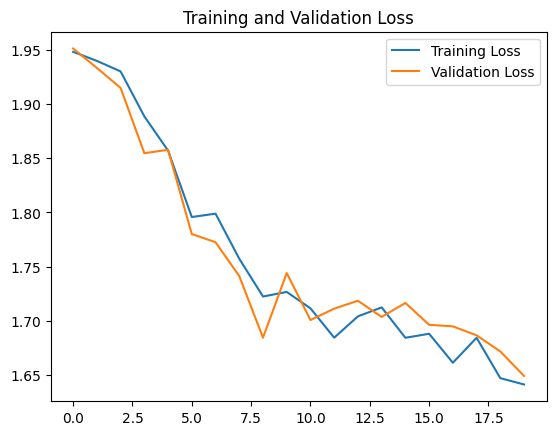

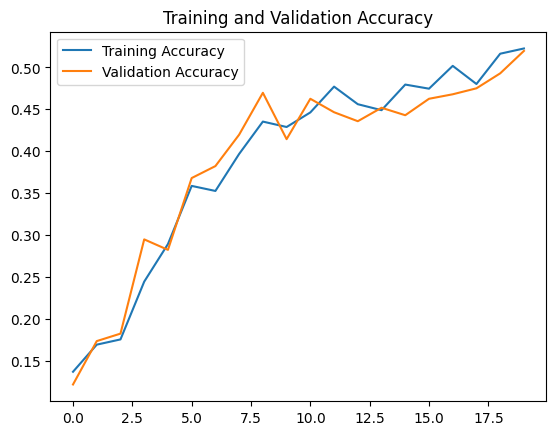

In [ ]:
loss_train = [i for i in training_loss_history]
acc_train = [i for i in training_accuracy_history]
loss_val = [i for i in validation_loss_history]
acc_val = [i for i in validation_accuracy_history]

plt.plot(loss_train , label = 'Training Loss')
plt.plot(loss_val , label = 'Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

print('\n\n')

plt.plot(acc_train , label = 'Training Accuracy')
plt.plot(acc_val , label = 'Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
y_true = []
y_preds = []

model.eval()

for i, data in enumerate(test_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels
    predicted = model(inputs)

    predicted = torch.argmax(predicted, dim=1)
    labels = torch.argmax(labels, dim=1)

    for i in predicted:
      y_preds.append(INSTRUMENTS[i])

    for i in labels:
      y_true.append(INSTRUMENTS[i])



In [ ]:
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

       flute       0.62      0.62      0.62        72
      guitar       0.62      0.30      0.41        82
        harp       0.60      0.60      0.60        83
       piano       0.35      0.44      0.39        73
   saxophone       0.42      0.56      0.48        89
     trumpet       0.60      0.49      0.54        80
      violin       0.61      0.65      0.63        81

    accuracy                           0.53       560
   macro avg       0.55      0.52      0.52       560
weighted avg       0.55      0.53      0.52       560



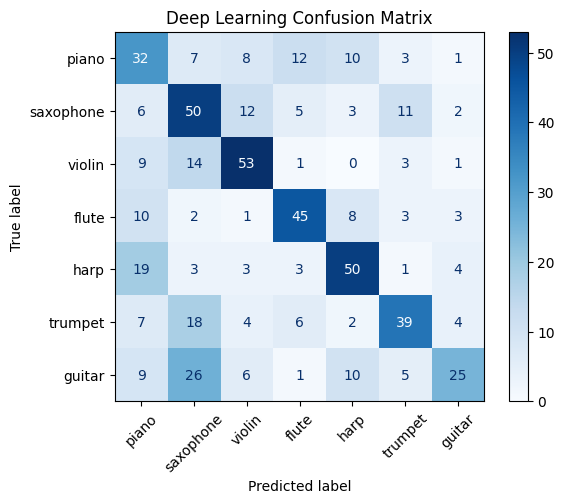

In [ ]:
conf_matrix = confusion_matrix(y_true, y_preds, labels = INSTRUMENTS)
conf_matrix_display = ConfusionMatrixDisplay(conf_matrix, display_labels = INSTRUMENTS)

conf_matrix_display.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Deep Learning Confusion Matrix")
plt.show()